In [1]:
### prepare packages

import matplotlib as mpl
import os
import errno
import PVTIclass_modified as PVTImaterials
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable, ImageGrid

In [2]:
### prepare figure configurations

# Solve the problem of plt.rc('text', usetex=True)
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2019/bin/x86_64-darwin'

# Memory saving
plt.close('all')

# Publication Quality Figure Parameters
# plt.rc('font', family='sans-serif', serif='Arial')   # Spend a long time dealing with this. 
plt.rc('font', family='Liberation Mono')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('savefig', dpi=300)

jetcmap = plt.cm.get_cmap("jet", 9) #generate a jet map with 10 values "rainbow", "jet", YlOrRd
jet_vals = jetcmap(np.arange(9)) #extract those values as an array 
jet_vals[0] = [1.0, 1, 1.0, 1] #change the first value 
jet_vals[8] = [0.0, 0, 0.0, 1] #change the first value 
new_jet = mpl.colors.LinearSegmentedColormap.from_list("mine", jet_vals) 

jetcmap = plt.cm.get_cmap("YlOrRd", 9) #generate a jet map with 10 values "rainbow", "jet", YlOrRd
jet_vals = jetcmap(np.arange(9)) #extract those values as an array 
jet_vals[0] = [1.0, 1, 1.0, 1] #change the first value 
# jet_vals[8] = [0.0, 0, 0.0, 1] #change the first value 
new_YlOrRd = mpl.colors.LinearSegmentedColormap.from_list("mine", jet_vals)

In [122]:
### prepare load data

## constants
me = 9.1e-31
mp = 1836. * me
mc = 12. * mp   # Carbon
mf = 19. * mp   # Flourine
mh = 4.  * mp   # He

## START: Change the parameters here accordingly ---------------

# target matieral
mi = mc * 0.86 + mp * 0.14  # target, CH2
mb = mh                     # background gas, He

# data directory

# --- FIND A BUG IN BC FOR TEMPERATURE
MHD_prefix = 'PIC_SHOCK_GAS_test4'
# MHD_prefix = 'PIC_SHOCK_test2_gas'

# time related
time_stop     = 20e-9
time_out_freq = 2e-9
time_out_num  = int(time_stop / time_out_freq + 1)

ii = 3  # number of the output file
time_now = ii * time_out_freq

## END:  Change the parameters here accordingly ---------------

## set saving path
MHD_workdir = "/travail/wyao/data/" + MHD_prefix + "/"
MHD_plots   = MHD_workdir + "plots/"

# create a directory to save plots
if not os.path.exists(MHD_plots):
    try:
        os.makedirs(MHD_plots, 0755);print("Plots directory is created.")
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

In [123]:
### get data

a = PVTImaterials.PVTI(MHD_workdir, MHD_prefix, ii)  # May take a long time
a.GetData(density=True,        # mass density
          Z=True,              # ionization 
          emission=True,       # recombination radiation
          V=True,              # velocity
          B=True,              # magnetic field
          E=True,              # electric field
          Ti=True,             # ion temperature
          Te=True,             # electron temperature
          J=True,              # current
          material2=True,      # background information
          )

# transform data shape
rho = a.cube(a.d)
Zeff = a.cube(a.Z)
Vx  = a.cube(a.V[:,0])
Vy  = a.cube(a.V[:,1])
Vz  = a.cube(a.V[:,2])
Te  = a.cube(a.Te)
Ti  = a.cube(a.Ti)
em  = a.cube(a.em)
Jx  = a.cube(a.J[:,0])
Jy  = a.cube(a.J[:,1])
Jz  = a.cube(a.J[:,2])
Bx  = a.cube(a.B[:,0])
By  = a.cube(a.B[:,1])
Bz  = a.cube(a.B[:,2])

Ex  = a.cube(a.E[:,0])
Ey  = a.cube(a.E[:,1])
Ez  = a.cube(a.E[:,2])

rho_gas = a.cube(a.gas_band_rho)  # for the background mass density

In [114]:
# get cell number information
(x1,x2,y1,y2,z1,z2) = a.mesh.GetExtent()
nxt = x2
nyt = y2
nzt = z2

# get simulation bounds, in default unit [m]
bounds = a.mesh.GetBounds()
xmin   = bounds[0] * 1e3  # unit of mm
xmax   = bounds[1] * 1e3
ymin   = bounds[2] * 1e3
ymax   = bounds[3] * 1e3
zmin   = bounds[4] * 1e3
zmax   = bounds[5] * 1e3

# get simulation resolution
dx = xmax/nxt/1e3

In [115]:
# Publication Quality Figure Parameters
plt.rc('font', family='sans-serif', serif='Arial')   # Spend a long time dealing with this. 
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=18)
plt.rc('savefig', dpi=300)

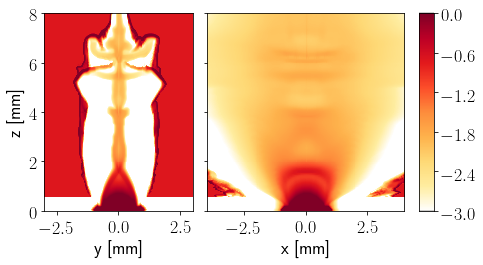

In [119]:
## plot the ion density distribution

ni = rho     / mi  / 1e6 # number density in cm^-3
# nb = rho_gas / mb  / 1e6
ne = ni * Zeff

# ni = ni + nb

# rho = rho + rho_gas
rho_n_gas = rho + rho_gas

nix = np.sum(ni,axis=0)*dx/1e4  # yz-plane
nex = np.sum(ne,axis=0)*dx/1e4  # yz-plane

width = 3.487 * 2# width of an one-column journal, for yz-plane
height = width /1.618 / 1.0# golden ratio

up  = 0
low = -3
h = cm.colors.Normalize(vmin=low,vmax=up)

col_map = new_YlOrRd   # new_jet, 'hot_r' or 'jet', 'YlOrRd',  'seismic'
apc = 'auto'  # 'auto', '0.5' or 'equal' (highly recommanded)

# set plotting extent
yz_extent = [ymin-ymax/2.0, ymax-ymax/2.0, zmin, zmax]
xz_extent = [xmin-xmax/2.0, xmax-xmax/2.0, zmin, zmax]

fig = plt.figure(figsize=(width, height))

grid = ImageGrid(fig, 111,
                 nrows_ncols=(1,2),
                 axes_pad=0.2,
                 share_all=False,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="10%",
                 cbar_pad=0.2,
                 aspect = True
                 )

im0 = grid[0].imshow(np.transpose(np.log10(rho_n_gas[nxt/2,:,:])),
# im0 = grid[0].imshow(np.transpose((rho_gas[nxt/2,:,:])),
# im0 = grid[0].imshow(np.transpose(np.log10(rho[nxt/2,:,:])),
                    extent = yz_extent,
                    interpolation = 'nearest',
                    norm = h,
                    cmap = col_map,
                    aspect = apc,
                    origin = 'lower',
                    )
grid[0].set_ylabel('z [mm]')#,fontsize=24)
grid[0].set_xlabel('y [mm]')#,fontsize=24)
# grid[0].set_title('ni',fontsize=24)

im1 = grid[1].imshow(np.transpose(np.log10(rho_n_gas[:,nyt/2,:])), 
# im1 = grid[1].imshow(np.transpose((rho_gas[:,nyt/2,:])), 
# im1 = grid[1].imshow(np.transpose(np.log10(rho[:,nyt/2,:])),  
                    extent = xz_extent,
                    interpolation = 'nearest',
                    norm = h,
                    cmap = col_map,
                    aspect = apc,
                    origin = 'lower',
                    )
# grid[1].set_ylabel('z [mm]')#,fontsize=24)
grid[1].set_xlabel('x [mm]')#,fontsize=24)
# grid[1].set_xticks([-5, 0, 5])
# grid[1].set_title('ne',fontsize=24)

cb = grid[1].cax.colorbar(im1)
# cb.set_label_text('number density [$cm^{-3}$]')
# grid[1].cax.toggle_label(True)
# grid[1].cax.set_yticks([12, 13, 14])

# fig.suptitle('time = {:.1e} s'.format(time_now),fontsize=24)
fig.set_size_inches(width, height)

plt.show()

In [120]:
fname = MHD_plots+MHD_prefix+"_rho_slice_rhogas"+"{:.1e}".format(time_now*2e9)+"ns.png"
fig.savefig(fname,bbox_inches='tight')

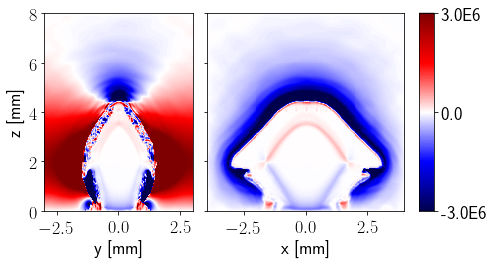

In [111]:
## plot the ion density distribution

ni = rho     / mi  / 1e6 # number density in cm^-3
# nb = rho_gas / mb  / 1e6
ne = ni * Zeff

# ni = ni + nb

# rho = rho + rho_gas
rho_n_gas = rho + rho_gas

nix = np.sum(ni,axis=0)*dx/1e4  # yz-plane
nex = np.sum(ne,axis=0)*dx/1e4  # yz-plane

width = 3.487 * 2# width of an one-column journal, for yz-plane
height = width /1.618 / 1.0# golden ratio

up  = 3e6
low = -up
h = cm.colors.Normalize(vmin=low,vmax=up)

col_map = 'seismic'   # new_jet, 'hot_r' or 'jet', 'YlOrRd',  'seismic'
apc = 'auto'  # 'auto', '0.5' or 'equal' (highly recommanded)

# set plotting extent
yz_extent = [ymin-ymax/2.0, ymax-ymax/2.0, zmin, zmax]
xz_extent = [xmin-xmax/2.0, xmax-xmax/2.0, zmin, zmax]

fig = plt.figure(figsize=(width, height))

grid = ImageGrid(fig, 111,
                 nrows_ncols=(1,2),
                 axes_pad=0.2,
                 share_all=False,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="10%",
                 cbar_pad=0.2,
                 aspect = True
                 )

im0 = grid[0].imshow(np.transpose((Ey[nxt/2,:,:])),
                    extent = yz_extent,
                    interpolation = 'nearest',
                    norm = h,
                    cmap = col_map,
                    aspect = apc,
                    origin = 'lower',
                    )
grid[0].set_ylabel('z [mm]')#,fontsize=24)
grid[0].set_xlabel('y [mm]')#,fontsize=24)
# grid[0].set_title('ni',fontsize=24)

im1 = grid[1].imshow(np.transpose((Ey[:,nyt/2,:])),  
                    extent = xz_extent,
                    interpolation = 'nearest',
                    norm = h,
                    cmap = col_map,
                    aspect = apc,
                    origin = 'lower',
                    )
# grid[1].set_ylabel('z [mm]')#,fontsize=24)
grid[1].set_xlabel('x [mm]')#,fontsize=24)
# grid[1].set_xticks([-5, 0, 5])
# grid[1].set_title('ne',fontsize=24)

cb = grid[1].cax.colorbar(im1)
# cb.set_label_text('number density [$cm^{-3}$]')
# grid[1].cax.toggle_label(True)
# grid[1].cax.set_yticks([12, 13, 14])
cb.ax.set_yticks([up, 0, low])
cb.ax.set_yticklabels(['3.0E6', '0.0', '-3.0E6'])

# fig.suptitle('time = {:.1e} s'.format(time_now),fontsize=24)
fig.set_size_inches(width, height)

plt.show()

In [109]:
fname = MHD_plots+MHD_prefix+"_Ez_slice"+"{:.1e}".format(time_now*2e9)+"ns.png"
fig.savefig(fname,bbox_inches='tight')

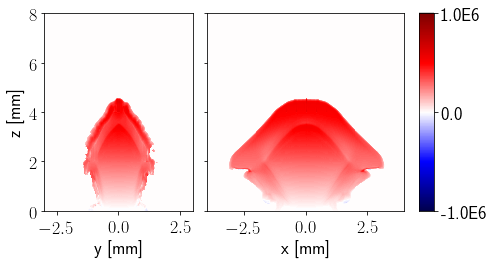

In [136]:
## plot the ion density distribution

ni = rho     / mi  / 1e6 # number density in cm^-3
# nb = rho_gas / mb  / 1e6
ne = ni * Zeff

# ni = ni + nb

# rho = rho + rho_gas
rho_n_gas = rho + rho_gas

nix = np.sum(ni,axis=0)*dx/1e4  # yz-plane
nex = np.sum(ne,axis=0)*dx/1e4  # yz-plane

width = 3.487 * 2# width of an one-column journal, for yz-plane
height = width /1.618 / 1.0# golden ratio

up  = 1e6
low = -up
h = cm.colors.Normalize(vmin=low,vmax=up)

col_map = 'seismic'   # new_jet, 'hot_r' or 'jet', 'YlOrRd',  'seismic'
apc = 'auto'  # 'auto', '0.5' or 'equal' (highly recommanded)

# set plotting extent
yz_extent = [ymin-ymax/2.0, ymax-ymax/2.0, zmin, zmax]
xz_extent = [xmin-xmax/2.0, xmax-xmax/2.0, zmin, zmax]

fig = plt.figure(figsize=(width, height))

grid = ImageGrid(fig, 111,
                 nrows_ncols=(1,2),
                 axes_pad=0.2,
                 share_all=False,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="10%",
                 cbar_pad=0.2,
                 aspect = True
                 )

im0 = grid[0].imshow(np.transpose((Vz[nxt/2,:,:])),
                    extent = yz_extent,
                    interpolation = 'nearest',
                    norm = h,
                    cmap = col_map,
                    aspect = apc,
                    origin = 'lower',
                    )
grid[0].set_ylabel('z [mm]')#,fontsize=24)
grid[0].set_xlabel('y [mm]')#,fontsize=24)
# grid[0].set_title('ni',fontsize=24)

im1 = grid[1].imshow(np.transpose((Vz[:,nyt/2,:])),  
                    extent = xz_extent,
                    interpolation = 'nearest',
                    norm = h,
                    cmap = col_map,
                    aspect = apc,
                    origin = 'lower',
                    )
# grid[1].set_ylabel('z [mm]')#,fontsize=24)
grid[1].set_xlabel('x [mm]')#,fontsize=24)
# grid[1].set_xticks([-5, 0, 5])
# grid[1].set_title('ne',fontsize=24)

cb = grid[1].cax.colorbar(im1)
# cb.set_label_text('number density [$cm^{-3}$]')
# grid[1].cax.toggle_label(True)
# grid[1].cax.set_yticks([12, 13, 14])
cb.ax.set_yticks([up, 0, low])
cb.ax.set_yticklabels(['1.0E6', '0.0', '-1.0E6'])

# fig.suptitle('time = {:.1e} s'.format(time_now),fontsize=24)
fig.set_size_inches(width, height)

plt.show()

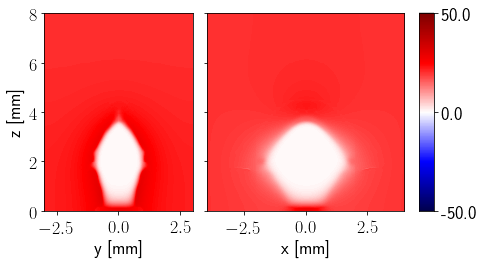

In [134]:
## plot the ion density distribution

ni = rho     / mi  / 1e6 # number density in cm^-3
# nb = rho_gas / mb  / 1e6
ne = ni * Zeff

# ni = ni + nb

# rho = rho + rho_gas
rho_n_gas = rho + rho_gas

nix = np.sum(ni,axis=0)*dx/1e4  # yz-plane
nex = np.sum(ne,axis=0)*dx/1e4  # yz-plane

width = 3.487 * 2# width of an one-column journal, for yz-plane
height = width /1.618 / 1.0# golden ratio

up  = 50
low = -up
h = cm.colors.Normalize(vmin=low,vmax=up)

col_map = 'seismic'   # new_jet, 'hot_r' or 'jet', 'YlOrRd',  'seismic'
apc = 'auto'  # 'auto', '0.5' or 'equal' (highly recommanded)

# set plotting extent
yz_extent = [ymin-ymax/2.0, ymax-ymax/2.0, zmin, zmax]
xz_extent = [xmin-xmax/2.0, xmax-xmax/2.0, zmin, zmax]

fig = plt.figure(figsize=(width, height))

grid = ImageGrid(fig, 111,
                 nrows_ncols=(1,2),
                 axes_pad=0.2,
                 share_all=False,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="10%",
                 cbar_pad=0.2,
                 aspect = True
                 )

im0 = grid[0].imshow(np.transpose((Bx[nxt/2,:,:])),
                    extent = yz_extent,
                    interpolation = 'nearest',
                    norm = h,
                    cmap = col_map,
                    aspect = apc,
                    origin = 'lower',
                    )
grid[0].set_ylabel('z [mm]')#,fontsize=24)
grid[0].set_xlabel('y [mm]')#,fontsize=24)
# grid[0].set_title('ni',fontsize=24)

im1 = grid[1].imshow(np.transpose((Bx[:,nyt/2,:])),  
                    extent = xz_extent,
                    interpolation = 'nearest',
                    norm = h,
                    cmap = col_map,
                    aspect = apc,
                    origin = 'lower',
                    )
# grid[1].set_ylabel('z [mm]')#,fontsize=24)
grid[1].set_xlabel('x [mm]')#,fontsize=24)
# grid[1].set_xticks([-5, 0, 5])
# grid[1].set_title('ne',fontsize=24)

cb = grid[1].cax.colorbar(im1)
# cb.set_label_text('number density [$cm^{-3}$]')
# grid[1].cax.toggle_label(True)
# grid[1].cax.set_yticks([12, 13, 14])
cb.ax.set_yticks([up, 0, low])
cb.ax.set_yticklabels(['50.0', '0.0', '-50.0'])

# fig.suptitle('time = {:.1e} s'.format(time_now),fontsize=24)
fig.set_size_inches(width, height)

plt.show()

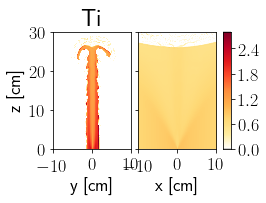

In [29]:
## plot the temperatures distribution

width = 3.487 * 1# width of an one-column journal, for yz-plane
height = width /1.618 / 1.0# golden ratio

up  = 5
low = 0
h = cm.colors.Normalize(vmin=low,vmax=up)

col_map = new_YlOrRd   # new_jet, 'hot_r' or 'jet', 'YlOrRd',  'seismic'
apc = 'equal'  # 'auto', '0.5' or 'equal' (highly recommanded)

fig = plt.figure(figsize=(width, height))

grid = ImageGrid(fig, 111,
                 nrows_ncols=(1,2),
                 axes_pad=0.1,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="10%",
                 cbar_pad=0.1,
                 aspect = True
                 )
im0 = grid[0].imshow(np.transpose((Te[nxt/2,:,:])),
                    extent = yz_extent,
                    interpolation = 'nearest',
#                     norm = h,
                    cmap = col_map,
                    aspect = apc,
                    origin = 'lower',
                    )
grid[0].set_ylabel('z [cm]')#,fontsize=24)
grid[0].set_xlabel('y [cm]')#,fontsize=24)
# grid[0].set_title('Ti',fontsize=24)

im1 = grid[1].imshow(np.transpose((Te[:,nyt/2,:])),
                    extent = xz_extent,
                    interpolation = 'nearest',
#                     norm = h,
                    cmap = col_map,
                    aspect = apc,
                    origin = 'lower',
                    )
grid[1].set_ylabel('z [cm]')#,fontsize=24)
grid[1].set_xlabel('x [cm]')#,fontsize=24)
# grid[1].set_title('Te',fontsize=24)

cb = grid[1].cax.colorbar(im1)
# cb.set_label_text('Temperatures [eV]')
grid[1].cax.toggle_label(True)

# fig.suptitle('time = {:.1e} s'.format(time_now),fontsize=24)
fig.set_size_inches(width, height)

plt.show()

In [298]:
fname = MHD_plots+MHD_prefix+"_temperatures_slice"+"{:.1e}".format(time_now*1e6)+"us.png"
fig.savefig(fname,bbox_inches='tight')

In [308]:
### Plot magnetic field



In [309]:
Te[nxt/2, nyt/2, 0]

0.8872108

In [310]:
Ti[nxt/2, nyt/2, 0]

0.41867796

In [311]:
ni[nxt/2, nyt/2, 0]

2.0158692e+19

In [312]:
Zeff[nxt/2, nyt/2, 0]

1.4522313

In [313]:
Vz[nxt/2, nyt/2, 0]

33387.566

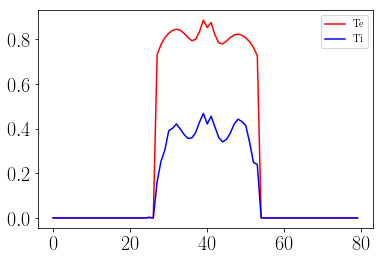

In [325]:
plt.plot(Te[nxt/2,:,0], '-r', label='Te')
plt.plot(Ti[nxt/2,:,0], '-b', label='Ti')
plt.legend()

In [5]:
import numpy as np
s = (320, 11)
ss = np.zeros(s)

In [6]:
np.shape(ss)

(320, 11)

In [83]:
160 * 160 * 240

6144000

In [87]:
1.25 * 16

20.0

In [88]:
180 / 9

20